In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
import string


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
import io

train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
train_df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#Text Preprocessing

In [ ]:
import re

tweet = train_df['text']

for i in range(len(train_df)):
  tweet[i] = re.sub('&amp', '&', tweet[i]) #turns '&amp to &'
  tweet[i] = re.sub(r'http\S+', '', tweet[i]) #removes links
  tweet[i] = re.sub(r'(@.*?)[\s]', ' ', tweet[i]) #removes mentions
  tweet[i] = re.sub(r'\s+', ' ', tweet[i]).strip() #removes trailing whitespace



stop_words = set(stopwords.words('english'))
stop_words.update(['http','https','via','...','..', "'s",'u',"'m"])
special_chars = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

preprocessed_data = []
labels = []

for i in range(len(train_df)):
  tweet = train_df['text'].iloc[i]
  label = train_df['target'].iloc[i]
  tokens = word_tokenize(tweet.lower())
  filtered_tokens = [token for token in tokens if token.casefold() not in stop_words]
  filtered_tokens = [token for token in filtered_tokens if token not in special_chars]
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
  #preprocessed_tweet = ' '.join(lemmatized_tokens)
  preprocessed_data.append(lemmatized_tokens) #preprocessed_data contains lists of words in each tweet.
  labels.append(label)

In [5]:
print(train_df['text'].iloc[0])
print(preprocessed_data[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']


#Train Word2Vec Model

References:
1) https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

2) https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#Word2Vec_for_text_classification_example

3) https://www.tensorflow.org/text/tutorials/word2vec#vectorize_an_example_sentence

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import gensim

In [7]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, labels, test_size=0.2, random_state=101)

In [8]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=1)

In [9]:
w2v_model.wv.index_to_key[:10] #Words that appeared in the training data

["n't",
 'like',
 'fire',
 'get',
 'new',
 'one',
 'people',
 'news',
 'video',
 'disaster']

In [10]:
w2v_model.wv.most_similar('flood') #Words in training data that are similar to "flood".

[('get', 0.9646653532981873),
 ('fire', 0.9638156890869141),
 ("n't", 0.9613969326019287),
 ('2', 0.9606778025627136),
 ('u', 0.9592340588569641),
 ('people', 0.9584516882896423),
 ('one', 0.957527756690979),
 ('new', 0.9573127031326294),
 ('emergency', 0.9548925161361694),
 ('police', 0.9548547863960266)]

In [11]:
# w2v_model.wv is an array of vectors. There is a vector for each word in the training data.
# w2v_model.wv[0] is the vector of size 100 for the first word of the training data.

words = set(w2v_model.wv.index_to_key )

X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in X_train], dtype='object')

X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])  for ls in X_test], dtype='object')

In [12]:
X_train_vect[1].shape #Vector of size 100 for each 9 words in the second training example in X_train

#It has 9 many vectors of size 100.

(9, 100)

In [13]:
for i, v in enumerate(X_train_vect):

    if i <= 2:
      print(len(X_train[i]), len(v))

#v here is 10 vectors of size 100 for the first training example, 9 vectors of size 100 for the second and so on.

10 10
9 9
6 6


In [14]:
# Compute sentence (tweet) vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [15]:
print(len(X_train_vect_avg))
print(len(X_train_vect_avg[0]))

#For each tweet of X_train there is a vector of size 100 now.

6090
100


In [16]:
# Are our sentence vector lengths consistent? Yes!
for i, v in enumerate(X_train_vect_avg):
    if i<=2:
      print(len(X_train[i]), len(v))

10 100
9 100
6 100


##### **Now, I will train the previous models with the best hyperparameters found in Word2Vec setting.**

# SVM

In [ ]:
pipeline = Pipeline([('svc', SVC())])

parameters = {'svc__C':[0.01, 0.1, 1, 10],
               'svc__kernel':['linear', 'rbf','poly'],
               'svc__degree':[1,2,3]}

svm = GridSearchCV(pipeline,parameters,scoring='f1')
svm.fit(X_train_vect_avg,y_train)

GridSearchCV(estimator=Pipeline(steps=[('svc', SVC())]),
             param_grid={'svc__C': [0.01, 0.1, 1, 10], 'svc__degree': [1, 2, 3],
                         'svc__kernel': ['linear', 'rbf', 'poly']},
             scoring='f1')

In [ ]:
svm.best_params_

{'svc__C': 10, 'svc__degree': 1, 'svc__kernel': 'rbf'}

In [ ]:
svm_train_preds = svm.predict(X_train_vect_avg)
print(classification_report(y_train,svm_train_preds))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81      3450
           1       0.81      0.61      0.69      2640

    accuracy                           0.77      6090
   macro avg       0.78      0.75      0.75      6090
weighted avg       0.77      0.77      0.76      6090



In [ ]:
svm_val_preds = svm.predict(X_test_vect_avg)
print(classification_report(y_test,svm_val_preds))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       892
           1       0.68      0.57      0.62       631

    accuracy                           0.71      1523
   macro avg       0.70      0.69      0.69      1523
weighted avg       0.71      0.71      0.71      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

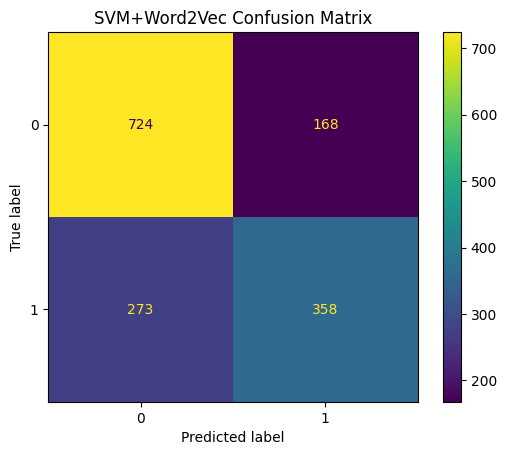

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,svm_val_preds), display_labels=svm.classes_).plot()
plt.title('SVM+Word2Vec Confusion Matrix')
plt.savefig('SVM_vect_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("SVM_vect_conf_matrix.png")

# Logistic Regression

In [ ]:
pipeline = Pipeline([('scaler',StandardScaler(with_mean=False)), ('log', LogisticRegression(solver='liblinear'))])

parameters = { 'log__C':[0.01, 0.1, 1, 10],
               'log__penalty':['l1', 'l2', 'elasticnet', None],
               }

log_model = GridSearchCV(pipeline,parameters, scoring='f1')
log_model.fit(X_train_vect_avg,y_train)

In [ ]:
log_model.best_params_

{'log__C': 10, 'log__penalty': 'l2'}

In [ ]:
log_train_preds = log_model.predict(X_train_vect_avg)
print(classification_report(y_train,log_train_preds))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      3450
           1       0.69      0.53      0.60      2640

    accuracy                           0.69      6090
   macro avg       0.69      0.67      0.67      6090
weighted avg       0.69      0.69      0.68      6090



In [ ]:
log_test_preds = log_model.predict(X_test_vect_avg)
print(classification_report(y_test,log_test_preds))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       892
           1       0.64      0.57      0.60       631

    accuracy                           0.69      1523
   macro avg       0.68      0.67      0.67      1523
weighted avg       0.68      0.69      0.68      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

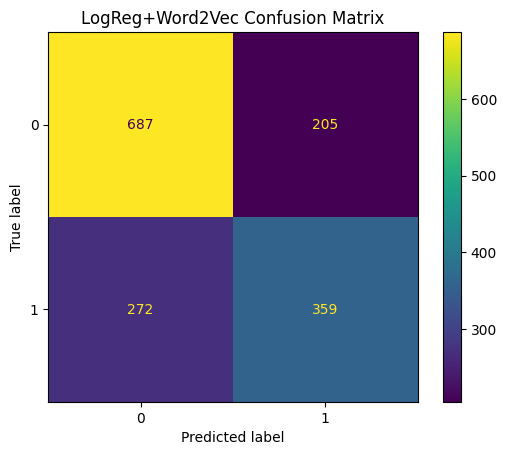

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,log_test_preds), display_labels=log_model.classes_).plot()
plt.title('LogReg+Word2Vec Confusion Matrix')
plt.savefig('LogReg_vect_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("LogReg_vect_conf_matrix.png")

# Naive Bayes

In [ ]:
#We scale the data because Naive Bayes does not accept negative values as input
sc = MinMaxScaler()
X_tr_sc = sc.fit_transform(X_train_vect_avg)
X_test_sc = sc.transform(X_test_vect_avg)

In [ ]:
nb = MultinomialNB()
nb.fit(X_tr_sc,y_train)

MultinomialNB()

In [ ]:
nb_train_preds = nb.predict(X_tr_sc)
print(classification_report(y_train,nb_train_preds))

              precision    recall  f1-score   support

           0       0.57      0.99      0.72      3450
           1       0.44      0.01      0.03      2640

    accuracy                           0.56      6090
   macro avg       0.50      0.50      0.37      6090
weighted avg       0.51      0.56      0.42      6090



In [ ]:
nb_test_preds = nb.predict(X_test_sc)
print(classification_report(y_test,nb_test_preds))

              precision    recall  f1-score   support

           0       0.59      0.98      0.73       892
           1       0.45      0.02      0.04       631

    accuracy                           0.58      1523
   macro avg       0.52      0.50      0.39      1523
weighted avg       0.53      0.58      0.45      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

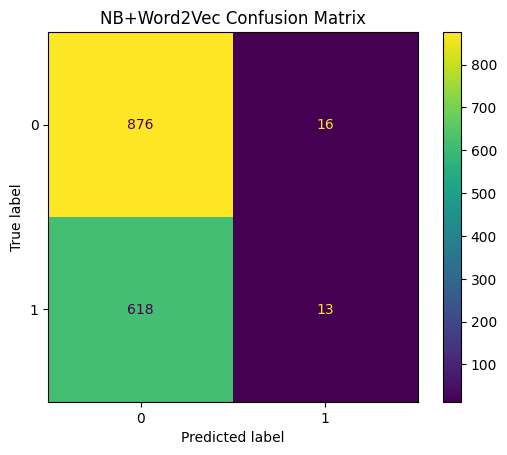

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,nb_test_preds), display_labels=nb.classes_).plot()
plt.title('NB+Word2Vec Confusion Matrix')
plt.savefig('NB_vect_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("NB_vect_conf_matrix.png")

# Random Forests

In [17]:
pipeline = Pipeline([('rf', RandomForestClassifier(random_state=101))])

parameters = {'rf__n_estimators':[100,500,1000],
              'rf__max_depth':[2,3,4,5],
             'rf__max_features':[10,50,100,None] }

rf = GridSearchCV(pipeline, parameters, scoring='f1')
rf.fit(X_train_vect_avg, y_train)

GridSearchCV(estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=101))]),
             param_grid={'rf__max_depth': [2, 3, 4, 5],
                         'rf__max_features': [10, 50, 100, None],
                         'rf__n_estimators': [100, 500, 1000]},
             scoring='f1')

In [18]:
rf.best_params_

{'rf__max_depth': 5, 'rf__max_features': 100, 'rf__n_estimators': 500}

In [19]:
rf_train_preds = rf.predict(X_train_vect_avg)
print(classification_report(y_train,rf_train_preds))

              precision    recall  f1-score   support

           0       0.68      0.94      0.79      3450
           1       0.83      0.41      0.55      2640

    accuracy                           0.71      6090
   macro avg       0.75      0.67      0.67      6090
weighted avg       0.74      0.71      0.68      6090



In [20]:
rf_test_preds = rf.predict(X_test_vect_avg)
print(classification_report(y_test,rf_test_preds))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76       892
           1       0.71      0.39      0.50       631

    accuracy                           0.68      1523
   macro avg       0.69      0.64      0.63      1523
weighted avg       0.69      0.68      0.66      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

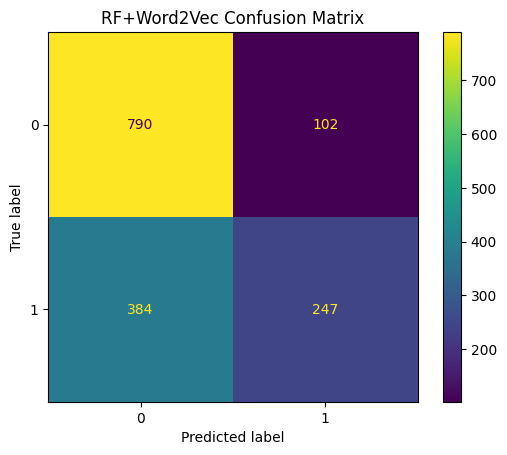

In [21]:
ConfusionMatrixDisplay(confusion_matrix(y_test,rf_test_preds), display_labels=rf.classes_).plot()
plt.title('RF+Word2Vec Confusion Matrix')
plt.savefig('rf_vect_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("rf_vect_conf_matrix.png")

# XGBoost

In [ ]:

pipeline = Pipeline([('xgbst', XGBClassifier(tree_method = 'hist', device='cuda', random_state=101))])

parameters = {'xgbst__n_estimators':[100,500,1000],
              'xgbst__max_depth':[2,3,4,5],
              'xgbst__learning_rate':[0.01,0.1,0.5,1],
              'xgbst__sampling_method':['uniform','gradient_based']
              }

xgbst = GridSearchCV(pipeline, parameters)
xgbst.fit(X_train_vect_avg, y_train)

GridSearchCV(estimator=Pipeline(steps=[('xgbst',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device='cuda',
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=No...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=101, ...))]),
             param_grid={'xgbst__learning_rate': [0.01, 0.1, 0.5, 1],
                         'xgbst__max_depth': [2, 3, 4, 5],
                         'xgbst__n_estimators': [100, 500, 1000],
                         'xgbst__sampling_method': ['uniform',
                                                    'gradient_based']})

In [ ]:
xgbst.best_params_

{'xgbst__learning_rate': 0.1,
 'xgbst__max_depth': 5,
 'xgbst__n_estimators': 500,
 'xgbst__sampling_method': 'uniform'}

In [ ]:
xg_train_preds = xgbst.predict(X_train_vect_avg)
print(classification_report(y_train,xg_train_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3450
           1       0.99      0.98      0.99      2640

    accuracy                           0.99      6090
   macro avg       0.99      0.99      0.99      6090
weighted avg       0.99      0.99      0.99      6090



In [ ]:
xg_test_preds = xgbst.predict(X_test_vect_avg)
print(classification_report(y_test,xg_test_preds))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       892
           1       0.66      0.58      0.62       631

    accuracy                           0.70      1523
   macro avg       0.69      0.69      0.69      1523
weighted avg       0.70      0.70      0.70      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

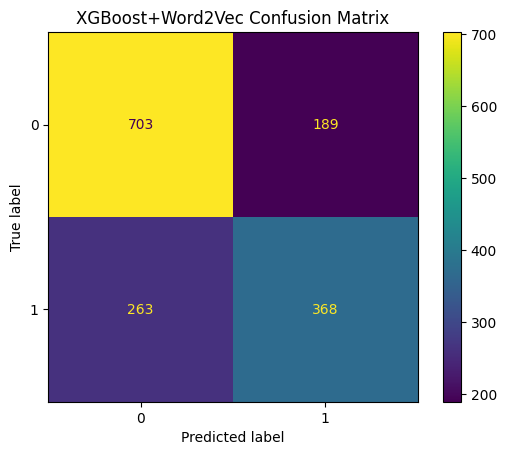

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,xg_test_preds), display_labels=xgbst.classes_).plot()
plt.title('XGBoost+Word2Vec Confusion Matrix')
plt.savefig('xgbst_vect_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("xgbst_vect_conf_matrix.png")

# KNN

In [ ]:
pipeline = Pipeline([('knn', KNeighborsClassifier())])

parameters = {'knn__n_neighbors':[1,2,3,5,10,15,20,25],
              'knn__weights':['uniform','distance']}

knn = GridSearchCV(pipeline,parameters,scoring='f1')
knn.fit(X_train_vect_avg,y_train)

GridSearchCV(estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 5, 10, 15, 20, 25],
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1')

In [ ]:
knn.best_params_

{'knn__n_neighbors': 1, 'knn__weights': 'uniform'}

In [ ]:
knn_train_preds = knn.predict(X_train_vect_avg)
print(classification_report(y_train,knn_train_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3450
           1       0.99      0.98      0.98      2640

    accuracy                           0.99      6090
   macro avg       0.99      0.99      0.99      6090
weighted avg       0.99      0.99      0.99      6090



In [ ]:
knn_test_preds = knn.predict(X_test_vect_avg)
print(classification_report(y_test,knn_test_preds))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71       892
           1       0.59      0.69      0.64       631

    accuracy                           0.68      1523
   macro avg       0.67      0.68      0.67      1523
weighted avg       0.69      0.68      0.68      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

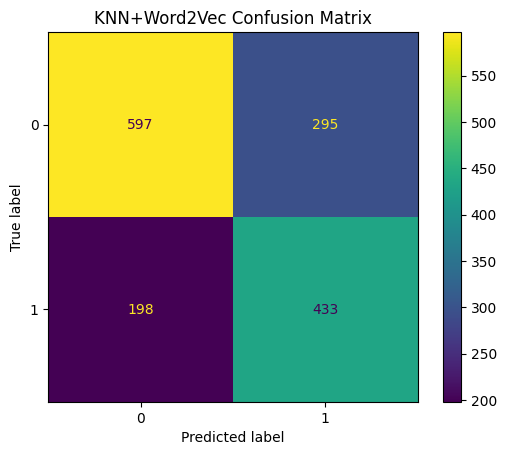

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test,knn_test_preds), display_labels=knn.classes_).plot()
plt.title('KNN+Word2Vec Confusion Matrix')
plt.savefig('KNN_vect_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("KNN_vect_conf_matrix.png")